In [132]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy as np
import pandas as pd

In [133]:
dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

dataset.replace( {'Male': 0,'Female':1, 'No': 0, 'Yes': 1, 'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4 }, inplace=True)
dataset.replace( {'Urban': 0, 'Rural': 1, 'formerly smoked': 1, 'never smoked': 0, 'smokes': 2, 'Unknown': 4 }, inplace=True)
dataset.drop(['Residence_type','ever_married','work_type','avg_glucose_level'], axis=1,inplace=True)
dataset.dropna(inplace=True)

features_names = ['gender','age','hypertension','heart_disease','bmi','smoking_status']
target_names = 'stroke'

target = dataset[target_names]
feature = dataset[features_names]

print(target.shape)
print(feature.shape)

print (target.value_counts())


(891,)
(891, 6)
0    682
1    209
Name: stroke, dtype: int64


In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,target,
    test_size=0.2,
    random_state=np.random.randint(10))

In [135]:
batch_size = 32
X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(float)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)

X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(float)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

In [136]:
from tensorflow import keras

inputs = keras.Input(shape=(6,))
h1 = keras.layers.Dense(13,activation=tf.nn.relu)(inputs)
h2 = keras.layers.Dense(6,activation=tf.nn.relu)(h1)
outputs = keras.layers.Dense(2)(h2)
model = keras.Model(inputs=inputs, outputs=outputs, name="stroke_model")

model.summary()

Model: "stroke_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_44 (Dense)            (None, 13)                91        
                                                                 
 dense_45 (Dense)            (None, 6)                 84        
                                                                 
 dense_46 (Dense)            (None, 2)                 14        
                                                                 
Total params: 189
Trainable params: 189
Non-trainable params: 0
_________________________________________________________________


In [137]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [138]:
next_batch_dataset = next(iter(train_dataset))
features,labels = next_batch_dataset
predictions = model(features)

print(f"Prediction: {tf.argmax(predictions, axis=1)}")
print(f"    Labels: {labels}")

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 1.]


In [139]:
def loss(model, x, y, training):
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

Loss test: 5.856122970581055


In [140]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [141]:
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")



Step: 0, Initial Loss: 5.856122970581055
Step: 1, Loss: 22.691951751708984


In [142]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  
        epoch_accuracy.update_state(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print(f"Epoch {epoch:03d}: Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")

Epoch 000: Loss: 1.677, Accuracy: 72.331%
Epoch 001: Loss: 0.547, Accuracy: 77.388%
Epoch 002: Loss: 0.523, Accuracy: 77.809%
Epoch 003: Loss: 0.514, Accuracy: 77.949%
Epoch 004: Loss: 0.508, Accuracy: 78.090%
Epoch 005: Loss: 0.504, Accuracy: 78.230%
Epoch 006: Loss: 0.501, Accuracy: 78.511%
Epoch 007: Loss: 0.498, Accuracy: 78.652%
Epoch 008: Loss: 0.497, Accuracy: 78.652%
Epoch 009: Loss: 0.495, Accuracy: 78.652%
Epoch 010: Loss: 0.493, Accuracy: 78.652%
Epoch 011: Loss: 0.492, Accuracy: 78.371%
Epoch 012: Loss: 0.491, Accuracy: 78.792%
Epoch 013: Loss: 0.489, Accuracy: 79.213%
Epoch 014: Loss: 0.487, Accuracy: 79.635%
Epoch 015: Loss: 0.486, Accuracy: 79.354%
Epoch 016: Loss: 0.485, Accuracy: 79.354%
Epoch 017: Loss: 0.484, Accuracy: 79.354%
Epoch 018: Loss: 0.484, Accuracy: 79.354%
Epoch 019: Loss: 0.483, Accuracy: 79.354%
Epoch 020: Loss: 0.483, Accuracy: 79.354%
Epoch 021: Loss: 0.483, Accuracy: 79.494%
Epoch 022: Loss: 0.482, Accuracy: 79.354%
Epoch 023: Loss: 0.482, Accuracy: 

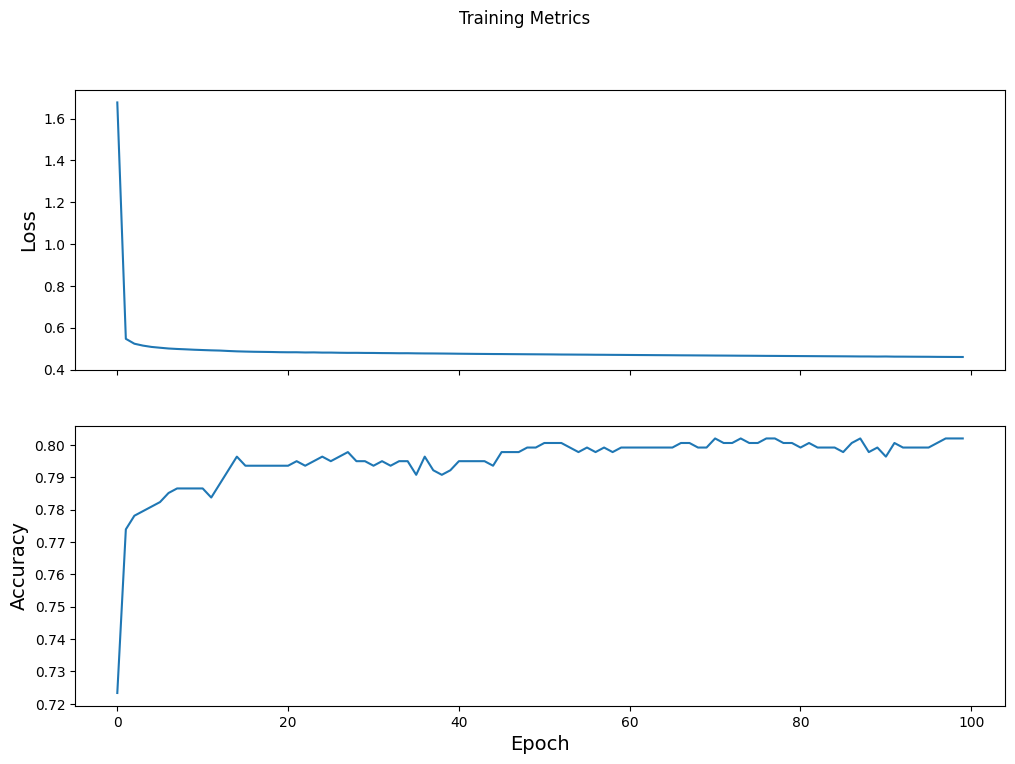

In [143]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)


axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()



In [144]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")

Test set accuracy: 79.330%


In [147]:
stroke_model = tf.saved_model.load('./model')

content = [[1,50,1,1,50,1]]
predict_dataset = tf.convert_to_tensor(content,dtype=tf.float32)
print(predict_dataset)
predictions = stroke_model(predict_dataset, training=False)
print(predictions[0])

tf.Tensor([[ 1. 50.  1.  1. 50.  1.]], shape=(1, 6), dtype=float32)
tf.Tensor([ -7.593065 -11.031267], shape=(2,), dtype=float32)


2022-11-11 10:53:15.289642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [146]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model/assets


In [100]:
model = Sequential()

model.add(Dense(3, input_shape=(10,), activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])